In [1]:
# Standard library imports
import os

# Third-party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# EMA Workbench imports
import ema_workbench
from ema_workbench import (
    Model, RealParameter, ScalarOutcome, MultiprocessingEvaluator,
    ema_logging, Constant, Scenario, HypervolumeMetric,
    GenerationalDistanceMetric, EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric, SpacingMetric, Constraint)
from ema_workbench.em_framework.optimization import (
    EpsilonProgress, to_problem, ArchiveLogger, epsilon_nondominated)
from ema_workbench.analysis import parcoords
from ema_workbench.em_framework.optimization import EpsilonProgress

# Custom problem formulation import
from problem_formulation import get_model_for_problem_formulation

In [6]:
def run_optimization(epsilon, nfe, scenarios, model):
    """
    Run optimization using the EMA Workbench.

    Parameters:
    epsilon (list): The epsilon values for the optimization.
    nfe (int): The number of function evaluations.
    scenarios (list): List of scenarios to be evaluated.
    model: The model to be used for optimization.

    Returns:
    tuple: A tuple containing results and convergences.
    """
    # Initialize lists to store results and convergence metrics
    results = []
    convergences = []
    # Use MultiprocessingEvaluator for parallel processing
    with MultiprocessingEvaluator(model) as evaluator:
        # Iterate over each scenario
        for scenario in scenarios:
            # Perform optimization three times for each scenario
            for i in range(3):
                # Define convergence metrics
                convergence_metrics = [
                    ArchiveLogger(
                        "./archives",
                        [l.name for l in model.levers],
                        [o.name for o in model.outcomes],
                        base_filename="optimization.tar.gz",
                    ),
                    EpsilonProgress(),
                ]

                # Run the optimization
                result, convergence = evaluator.optimize(
                    nfe=nfe,
                    searchover="levers",
                    epsilons=epsilon,
                    constraints=None,
                    convergence=convergence_metrics,
                    reference=scenario,
                )

                # Create result directory if it does not exist
                result_dir = "./archives"
                os.makedirs(result_dir, exist_ok=True)
                
                # Save the results and convergence metrics to CSV files
                result.to_csv(os.path.join(result_dir, f"result__scen{scenario.name}__seed{i}.csv"))
                pd.DataFrame(convergence).to_csv(os.path.join(result_dir, f"convergence__scen{scenario.name}__seed{i}.csv"))

                # Append the results and convergence metrics to the lists
                results.append(result)
                convergences.append(convergence)
    
    # Return the results and convergence metrics
    return results, convergences

In [9]:
if not os.path.exists('archives'):
    os.makedirs('archives')
    
if __name__ == '__main__':
    # Set up logging to stderr with INFO level
    ema_logging.log_to_stderr(ema_logging.INFO)

    # Get the model and steps for problem formulation 6
    model, steps = get_model_for_problem_formulation(2)

    # Load scenarios from a CSV file
    scenarios_df = pd.read_csv("./data/subset_scenarios.csv")

    # Initialize a list to store scenarios
    scenarios = []
    
    # Iterate over each row in the scenarios dataframe to create Scenario objects
    for index in range(scenarios_df.shape[0]):
        scenario = {}
        for column in scenarios_df:
            if (column == 'scenario') or (column=='scenario'):
                continue
            # Update the scenario dictionary with column values
            scenario.update({column: scenarios_df.loc[index, column]})

        # Create an EMA Workbench Scenario object
        ema_scenario = Scenario(scenarios_df.loc[index, 'scenario'], **scenario)
        # Append the scenario to the list
        scenarios.append(ema_scenario)

    # Define epsilon values for the optimization (if statement used for testing multiple epsilon values)
    epsilon_values = [[1000000, 1000000, 1000000, 1000000, 1000000]]
    # Set the number of function evaluations
    nfe = 20000

    # Iterate over each set of epsilon values
    for eps in epsilon_values:
        # Run optimization for the given epsilon values and scenarios
        results, convergences = run_optimization(eps, nfe, scenarios, model)

        # Load results from the archive files
        all_results = load_results_from_files("./archives")

        # Define outcomes of interest
        outcomes_of_interest = [
            'Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs', 
            'Evacuation Costs', 'Expected Number of Deaths' ]
        # Extract the outcomes from the results
        outcomes = all_results[outcomes_of_interest]

        # Get the limits for the parallel coordinates plot
        limits = parcoords.get_limits(outcomes)
        # Create a ParallelAxes object with the limits
        axes = parcoords.ParallelAxes(limits)
        # Plot the outcomes on the parallel coordinates plot
        axes.plot(outcomes)

        # Set the title and save the plot as an image file
        plt.title(f'Parallel Coordinates Plot for Epsilon {eps}')
        plt.savefig(f'parallel_coordinates_eps_{eps}.png')
        plt.show()


[MainProcess/INFO] pool started with 24 workers
20207it [06:01, 55.96it/s]                                                     
[MainProcess/INFO] optimization completed, found 283 solutions
20143it [06:58, 48.12it/s]                                                     
[MainProcess/INFO] optimization completed, found 222 solutions
20519it [07:49, 43.72it/s]                                                     
[MainProcess/INFO] optimization completed, found 249 solutions
20340it [07:51, 43.12it/s]                                                     
[MainProcess/INFO] optimization completed, found 260 solutions
20251it [07:51, 42.96it/s]                                                     
[MainProcess/INFO] optimization completed, found 295 solutions
20152it [07:50, 42.87it/s]                                                     
[MainProcess/INFO] optimization completed, found 267 solutions
100%|████████████████████████████████████| 20000/20000 [07:56<00:00, 41.97it/s]
[MainProcess/I

NameError: name 'load_results_from_files' is not defined

Number of policies: 1877


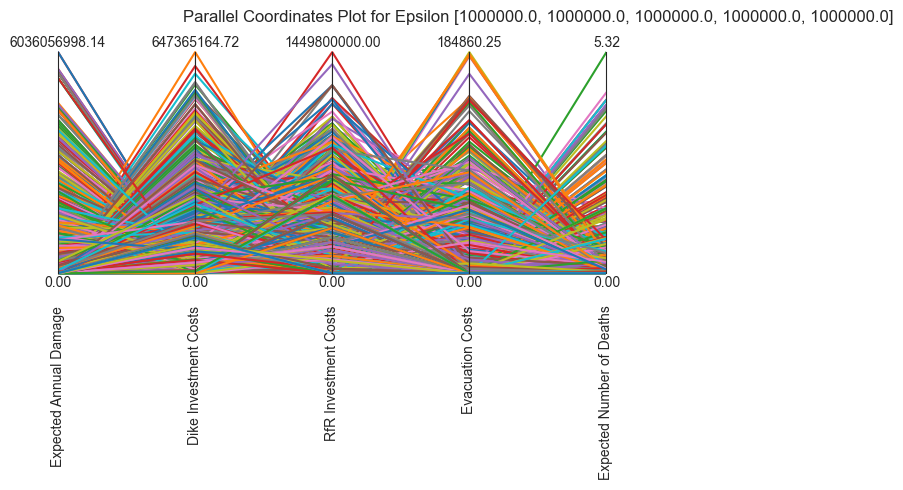

In [5]:
def load_results_from_files(directory):
    """
    Load and combine all CSV files from the specified directory into a single DataFrame.
    """
    all_results = []
    for file in os.listdir(directory):
        if file.endswith(".csv") and file.startswith("result__"):
            file_path = os.path.join(directory, file)
            df = pd.read_csv(file_path)
            all_results.append(df)
    if not all_results:
        raise ValueError(f"No result files found in {directory}")
    return pd.concat(all_results, ignore_index=True)

def visualize_results(directory, outcomes_of_interest, eps):
    """
    Visualize the results from the archive files using a parallel coordinates plot.
    """
    # Load results from the archive files
    all_results = load_results_from_files(directory)

    # Extract the outcomes of interest
    outcomes = all_results[outcomes_of_interest]

    # Get the limits for the parallel coordinates plot
    limits = parcoords.get_limits(outcomes)

    # Create a ParallelAxes object with the limits
    axes = parcoords.ParallelAxes(limits, fontsize=10)

    # Plot the outcomes on the parallel coordinates plot
    axes.plot(outcomes)

     # Print the number of policies
    print(f"Number of policies: {len(all_results)}")
    
    # Set the title and save the plot as an image file
    plt.title(f'Parallel Coordinates Plot for Epsilon {eps}')
    plt.savefig(f'parallel_coordinates_eps_{eps}.png')
    plt.show()

# Example usage
if __name__ == "__main__":
    # Define the directory containing the archive files
    archive_directory = "./archives"

    # Define the outcomes of interest
    outcomes_of_interest = [
        'Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs',
        'Evacuation Costs', 'Expected Number of Deaths'
    ]

    # Define epsilon value for the plot title
    eps = [1e6, 1e6, 1e6, 1e6, 1e6]

    # Visualize the results
    visualize_results(archive_directory, outcomes_of_interest, eps)

In [9]:
import pandas as pd

def filter_pareto_optimal_policies(results_df, objectives):
    """
    Filter out non-dominant policies and retain only Pareto-optimal policies.

    Parameters:
    - results_df (pd.DataFrame): DataFrame containing the policies and their objective values.
    - objectives (list): List of column names representing the objectives.

    Returns:
    - pd.DataFrame: DataFrame containing only Pareto-optimal policies.
    """
    # Extract the objective values
    objective_values = results_df[objectives].values

    # Initialize a boolean mask for Pareto-optimal policies
    is_pareto_optimal = [True] * len(objective_values)

    # Compare each policy with every other policy
    for i, policy_i in enumerate(objective_values):
        for j, policy_j in enumerate(objective_values):
            if i != j:
                # Check if policy_j dominates policy_i
                if all(policy_j <= policy_i) and any(policy_j < policy_i):
                    is_pareto_optimal[i] = False
                    break

    # Filter the DataFrame to retain only Pareto-optimal policies
    pareto_optimal_df = results_df[is_pareto_optimal]
    return pareto_optimal_df 

In [10]:
def get_minimizing_policies(results_df, objectives):
    """
    Filter Pareto-optimal policies and create a DataFrame of policies that minimize all outcomes.

    Parameters:
    - results_df (pd.DataFrame): DataFrame containing the policies and their objective values.
    - objectives (list): List of column names representing the objectives.

    Returns:
    - pd.DataFrame: DataFrame containing Pareto-optimal policies sorted to minimize all outcomes.
    """
    # Step 1: Filter Pareto-optimal policies
    pareto_optimal_policies = filter_pareto_optimal_policies(results_df, objectives)

    # Step 2: Sort policies by the sum of their objective values (minimizing all outcomes)
    pareto_optimal_policies["total_outcome"] = pareto_optimal_policies[objectives].sum(axis=1)
    sorted_policies = pareto_optimal_policies.sort_values(by="total_outcome")

    # Step 3: Drop the "total_outcome" column before returning
    return sorted_policies.drop(columns=["total_outcome"])

In [11]:
# Example usage
if __name__ == "__main__":
    # Define the directory containing the results files
    results_directory = "./archives"

    # Define the outcomes of interest
    objectives = [
        'Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs',
        'Evacuation Costs', 'Expected Number of Deaths'
    ]

    # Load the results
    results_df = load_results_from_files(results_directory)

    # Get policies that minimize all outcomes
    minimizing_policies = get_minimizing_policies(results_df, objectives)

    # Display the resulting DataFrame
    print("Policies that minimize all outcomes:")
    print(minimizing_policies)

Policies that minimize all outcomes:
      Unnamed: 0  0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  \
1876           0        0        0        0        0        0        0   
1875           0        0        0        0        0        0        0   
1873           0        0        0        0        0        0        0   
1871           0        0        0        0        0        0        0   
1872           0        0        0        0        0        0        0   
...          ...      ...      ...      ...      ...      ...      ...   
1694          33        1        0        0        0        0        0   
1788          58        1        0        0        0        0        0   
23            23        0        0        0        0        0        0   
52            23        0        0        0        0        0        0   
77            20        0        0        0        0        0        0   

      2_RfR 0  2_RfR 1  2_RfR 2  ...  A.5_DikeIncrease 0  A.5_DikeIncrease

C:\Users\ralph\AppData\Local\Temp\ipykernel_18600\485754464.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pareto_optimal_policies["total_outcome"] = pareto_optimal_policies[objectives].sum(axis=1)
